<a href="https://colab.research.google.com/github/amirarasteh1990/Examples/blob/main/test_EmmaFreja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
## INSTALL ALL REQUIRED PACKAGES
import importlib
if not importlib.util.find_spec("py_wake"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git
if not importlib.util.find_spec("topfarm"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git
if not importlib.util.find_spec("ed_win"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/edwin.git@main#egg=ed_win[interarray]

!pip install ssms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00


Coordinates for each turbine:
Turbine 1: (x=429258.33517452516, y=6148626.084410055)
Turbine 2: (x=427595.3087783677, y=6147609.638376683)


/usr/local/lib/python3.10/dist-packages/py_wake/deficit_models/noj.py:88: UserWarning: The NOJ model is not representative of the setup used in the literature. For this, use py_wake.literature.noj.Jensen_1983 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.noj.Jensen_1983')


Solving with heuristic(cpew)

0
[ True  True  True  True  True]
1339078.1655871163
1
[ True  True  True  True  True]
1339078.1655871163
2
[ True  True  True  True  True]
1339078.1655871163
3
[ True  True  True  True  True]
1339078.1655871163
4
[ True  True  True  True  True]
1339078.1655871163
5
[ True  True  True  True  True]
1339078.1655871163
6
[ True  True  True  True  True]
1339078.1655871163
7
[ True  True  True  True  True]
1339078.1655871163
8
[ True  True  True  True  True]
1339078.1655871163
9
[ True  True  True  True  True]
1339078.1655871163
10
[ True  True  True  True  True]
1339078.1655871163
Solved with Genetic Algorithm
Total length is: 6500.379444597653 meters
Total cable length in kilometers: 6.500379444597653
INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


TypeError: 'cost_comp.comp_2' <class CostModelComponent>: Error calling compute(), cable_position() missing 1 required positional argument: 'turb_init'

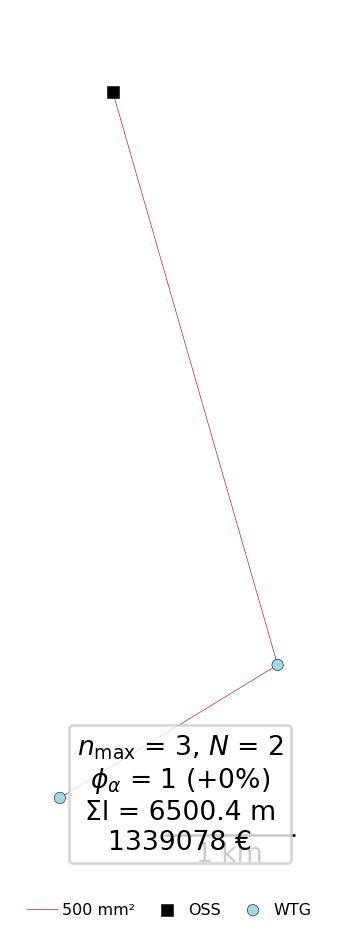

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 23 10:07:15 2024

@author: emmakochjorgensen
"""



#%% IMPORT ALL REQUIRED FUNCTIONS


import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle


from scipy.interpolate import griddata
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import interp2d
from scipy.interpolate import Rbf

from openmdao.api import n2

from ssms.models import model_path
from ssms.load_QLS import QLSModel, get_r2

from topfarm._topfarm import TopFarmProblem, TopFarmGroup
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.plotting import XYPlotComp
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm import SpacingConstraint, XYBoundaryConstraint
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation

from py_wake.examples.data.hornsrev1 import wt_x, wt_y, HornsrevV80, Hornsrev1Site
from py_wake import NOJ
from py_wake.utils.gradients import autograd

from ed_win.wind_farm_network import WindFarmNetwork, InterArrayDriver, GeneticAlgorithmDriver

from tabulate import tabulate

from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.drivers.random_search_driver import RandomizeTurbinePosition_Circle
from topfarm.easy_drivers import EasySimpleGADriver

from topfarm.easy_drivers import EasyRandomSearchDriver



#!pip install ed_win
#from ed_win.wind_farm_network import WindFarmNetwork, TwoStepHeuristicDriver

#%% SETUP OF SITE DATA
df = None  # Define df as a global variable

def load_data(csv_file):
    global df
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file, delimiter=';')
    return df


def convert_to_utm():
    global df
    # Convert latitude and longitude to UTM
    utm_coords = [utm.from_latlon(float(lat), float(lon)) for lat, lon in zip(df['latitude'], df['longitude'])]
    df['utm_easting'], df['utm_northing'], _, _ = zip(*utm_coords)
    return df

# Load data
df = load_data("Coordinates_Horn.csv")

# Convert to UTM
convert_to_utm()

x_site = np.array([df['utm_easting'].min(), df['utm_easting'].max(), df['utm_easting'].min(), df['utm_easting'].max()])
y_site = np.array([df['utm_northing'].min(), df['utm_northing'].max(), df['utm_northing'].min(), df['utm_northing'].max()])

#%% SETUP OF WIND FARM MODEL

# Set random seed
np.random.seed(1)

# Generate random indices for selecting positions from df
random_indices = np.random.randint(0, len(df), size=2)

# Extract random x and y coordinates from df using the random indices
x_init = df['utm_easting'].iloc[random_indices].values
y_init = df['utm_northing'].iloc[random_indices].values

# Ensure no duplicate coordinates
unique_positions = set()
unique_x = []
unique_y = []
for x, y in zip(x_init, y_init):
    position = (x, y)
    if position not in unique_positions:
        unique_positions.add(position)
        unique_x.append(x)
        unique_y.append(y)

# Update x_init and y_init with unique positions
x_init = np.array(unique_x)
y_init = np.array(unique_y)

# Print coordinates for each turbine
print("Coordinates for each turbine:")
for i, (x, y) in enumerate(zip(x_init, y_init), start=1):
    print(f"Turbine {i}: (x={x}, y={y})")


n_wt = len(x_init) #Number of turbines
wt = HornsrevV80() #WT model (the same as in Hornsrev1)
site = Hornsrev1Site() #Define the site
wf_model = NOJ(site, wt) #N.O. Jensen wake model for the WF
aep = wf_model(wt_x, wt_y).aep() #AEP model of this WF

#%% SETUP OF ELECTRICAL MODEL

#Fixed position for the substation(s)
substations_pos = np.asarray([[428000], [6153000]]).T

#Three types of cable, [thikness, n_wt, cost]
cables = np.array([[500, 3, 206], [800, 5, 287], [1000, 7, 406]])

turb_init = np.asarray([x_init, y_init]).T

def cable_position(turb_init, **kwargs):
    L = 0
    G = None

    try:
        wfn = WindFarmNetwork(turbines_pos=turb_init, substations_pos=substations_pos, cables=cables)
        G = wfn.optimize()
        print('Solved with Heuristics')
    except:
        wfn = WindFarmNetwork(turbines_pos=turb_init, substations_pos=substations_pos, cables=cables, drivers=[GeneticAlgorithmDriver()])
        G = wfn.optimize()
        print('Solved with Genetic Algorithm')

    L = G.size(weight="length")
    print('Total length is:', L, 'meters')

    return L / 1000, G  # Return both total cable length in kilometers and the optimized graph

# Calculate cable length and get the graph using x_init and y_init as separate inputs
total_cable_length, G = cable_position(turb_init)
print(f'Total cable length in kilometers: {total_cable_length}')

G.plot()



'''
def cable_position(x, y, **kwargs):
  L = 0
  turbines_pos = np.asarray([x, y]).T

  # Here we use the default format of the inputs (which is passing coordinates directly to the function).
  try:
      G1 = wfn.optimize()
      L = sum(length for _, _, length in G1.edges(data='length'))
      print('Edwin runs properly and L is ', L)
  except:
      L = 5000
  #L = 2000

  return L/1000  # total cable length

G = wfn.evaluate(cable_position(x_init, y_init))
L = sum(length for _, _, length in G.edges(data='length'))
print(L)
'''


#%% SETUP OF ECONOMICAL MODEL
# The economical model doesnt have to be money, could be CO2 as well

Drotor_vector = [wt.diameter()] * n_wt #Diameter of rotor
power_rated_vector = [float(wt.power(20))*1e-6] * n_wt
hub_height_vector = [wt.hub_height()] * n_wt


# add additional cost model inputs for shore distance, energy price, project lifetime, rated rotor speed and water depth
distance_from_shore = 30         # [km]
energy_price = 0.4               # [Euro/kWh] What we get per kWh
project_duration = 20            # [years]
rated_rpm_array = [12] * n_wt    # [rpm]
water_depth_array = [15] * n_wt  # [m]
omega = 0.0475                   # interest rate
LT = project_duration            # Life time of WF
eco_eval =  economic_evaluation(distance_from_shore, energy_price, project_duration)

#Move some economical calculations out of the functions, to make the optimization faster
#CAPEX
#Define the capital cost based on the MW
cost_WT = 1.1*10**6               #€/MW for the WT
CRF = omega / (1-(1+omega)**(-LT)) #recovery factor

#Tax rates pr ton of CO2
tax1 = 750 * 0.13
tax2 = 375 * 0.13
tax3 = 125 * 0.13

#OPEX
#Define the capital cost based on the MW
cost_fixed = 40*1000*n_wt*power_rated_vector[1]  #€/y
cost_var = 3.0                                   #€/MWh


def LCOE_CAPEX(AEP, CO2e_tax, monopile_cost, **kwargs):
  #AEP Corect unit
  AEP = AEP * 1000                   #MW

  #Support structure price
  #steel_cost                        #€ for the support stucture
  #cost_trans = 100000 * 1.17         #€/MW   Is included in ss

  #calculate cost of all capital expenditures (incl. CO2e tax)
  cost_CAPEX = cost_WT*n_wt*power_rated_vector[1] + CO2e_tax + monopile_cost

  #Calculate the LCOE CAPEX from the wind farm
  LCOE_CAPEX = ((cost_CAPEX)/(AEP))*CRF  #€/MWh

  #LCOE_CAPEX = np.sum(LCOE_CAPEX)
  return [LCOE_CAPEX, cost_CAPEX]

#  LCOE_CAPEX(AEP, CO2e_tax, steel_mass, steel_cost)



def LCOE_OPEX(AEP, **kwargs):
  #AEP Corect unit
  AEP = AEP * 1000                   #MW

  #Calculate the LCOE OPEX from the wind farm
  LCOE_OPEX = (cost_fixed)/AEP + cost_var           #€/MWh

  #LCOE_OPEX = np.sum(LCOE_OPEX)
  return LCOE_OPEX

def calculate_LCOE(LCOE_OPEX, LCOE_CAPEX, **kwargs):
  #Gather LCOE
  LCOE = LCOE_CAPEX + LCOE_OPEX
  return LCOE

## FIRST CO2 ECONOMICAL SETUP
# This wil optimize based on the GHG emissions

#Calculations for the steel in the tower
power_kW = power_rated_vector[1]*1000

tower_mass = (power_kW/10000)**(2.5/2)*628500*n_wt #kg
tower_cost = tower_mass *2.5                               #€ 2002 money

#Calculations for the nacelle, calculate mass
low_speed_shaft = (power_kW/5000)**(3/2)*27210
main_bearing = 0.0092*(8/600*wt.diameter()-0.033)*(wt.diameter()**2.5)*2
mechanical_brake_couplings = (power_kW/5000)**(3/2)*1000
bed_plate = wt.diameter()**1.953 *1.228
hydraulic_cooling_system = 0.08*power_kW
nacelle_cover = 13000*(power_kW/5000)**(2/2)
yaw_system = wt.diameter()**3.314 *0.0009*1.6

#Calculate cost
low_speed_shaft_cost = low_speed_shaft*3
main_bearing_cost = main_bearing*17.6
mechanical_brake_couplings_cost =1.9894*power_kW -0.1141
bed_plate_cost = wt.diameter()**0.85 *627.28
hydraulic_cooling_system_cost = 12*power_kW
nacelle_cover_cost = nacelle_cover*4
yaw_system_cost = wt.diameter()**2.964 *0.0339*2

nacelle_mass = (low_speed_shaft+main_bearing+mechanical_brake_couplings+bed_plate+hydraulic_cooling_system+nacelle_cover+yaw_system)*n_wt
nacelle_cost = (low_speed_shaft_cost+main_bearing_cost+mechanical_brake_couplings_cost+bed_plate_cost+hydraulic_cooling_system_cost+nacelle_cover_cost+yaw_system_cost)*n_wt
#print(nacelle_mass)
#print(tower_mass)
#print(calculate_steel_mass(5))

#%% SETUP OF WRAPPER FUNCTIONS

def water_depth_func(x, y, df):
    # Interpolate water depth from seabed elevation data
    points = df[['utm_easting', 'utm_northing']].values
    values = -df['elevation'].values  # Depth is negative of elevation

    # Perform Thin Plate Spline interpolation
    rbf = Rbf(points[:, 0], points[:, 1], values, function='thin_plate')
    water_depth = rbf(x, y)

    return np.maximum(0, water_depth)  # Ensure depth is nonnegative


def calculate_steel_mass(water_depth, **kwargs):
  #Calculations for the steel in the monopile and transition piece
  a = 21.3 * 1000
  b = 137.5 * 1000
  # Calculate cost using the lowest elevation
  monopile_cost = (a * water_depth + b) * 2 #Capacity of V80   2012 money
  # Calculate mass of steel
  monopile_mass1 = monopile_cost / 8.1  # €/kg

  monopile_mass = np.sum(monopile_mass1)
  monopile_cost = np.sum(monopile_cost)

  # Make sure the output is a number, not a vector
  steel_mass = monopile_mass + tower_mass + nacelle_mass #kg
  steel_cost = monopile_cost + tower_cost + nacelle_cost #€


  return [steel_mass, steel_cost, monopile_cost]


def cost_emissions(steel_mass,**kwargs):
  # From support_structure the mass of the structure is known
  # Then multiply with suitable CO2e from kjeldsen bachelor
  # Unit is t CO2e/t, is the steelmass in tons??
  CO2e =  3.62 * (steel_mass/1000) # steel_mass -> tons

  # From cable_length get the length of the cables
  # Make an assumption for CO2e pr m or km cable
  #CO2e_cab = 2 * cable_length

  #CO2e = 1.58e6 + CO2e_sup + CO2e_cab

  # Add the two CO2e's together, this is all of the GHG emission that are evaluated
  # Then multiply with one of the three taxes (model 1,2 or 3 from the danish agency)
  # Return the cost of the CO2 taxation
  CO2e_tax = CO2e * tax1
  return [CO2e,CO2e_tax]

# Define input parameters
RP = 2  # Rated power in MW (for example)
D = 80   # Rotor diameter in meters
HTrans = 12  # Height of transition piece in meters
WaterDepth = 20  # Water depth in meters
WaveHeight = 3.5  # Wave height in meters
WavePeriod = 6  # Wave period in seconds
WindSpeed = 9  # Average wind speed in m/s

#Update of values
def current_state_values (x, y, recorderSLSQP, recorderGA, **kwargs):
  LCOE_part1 = (((recorderGA['CO2e_tax'][1]/(recorderGA['AEP'][1]*1000))*CRF)/recorderGA['LCOE'][1])*100 #GWh->MWh
  LCOE_part2 = (((recorderSLSQP['CO2e_tax'][-1]/(recorderSLSQP['AEP'][-1]*1000))*CRF)/recorderSLSQP['LCOE'][-1])*100 #GWh->MWh
  lev_CO2_mass1 =((recorderGA['CO2e'][1]*10**6)/(recorderGA['AEP'][1]*10**6)) #t->g, GWh->kWh
  lev_CO2_mass2 =((recorderSLSQP['CO2e'][-1]*10**6)/(recorderSLSQP['AEP'][-1]*10**6)) #t->g, GWh->kWh
  CF1 = (recorderGA['AEP'][1]*1000)/(n_wt*power_rated_vector[1]*8760)*100 #GWh->MWh
  CF2 = (recorderSLSQP['AEP'][-1]*1000)/(n_wt*power_rated_vector[1]*8760)*100 #GWh->MWh
  difference_percentage = ((recorderGA['steel_mass'][1] - recorderSLSQP['steel_mass'][-1]) / recorderGA['steel_mass'][1]) * 100

  results = [
    ["Water depth", np.sum(recorderGA['water_depth'][1])/n_wt, np.sum(recorderSLSQP['water_depth'][-1])/n_wt, "m"],
    ["AEP", recorderGA['AEP'][1] , recorderSLSQP['AEP'][-1], "Gwh"],
    ["CF", CF1, CF2, "%"],
    ["steel mass", recorderGA['steel_mass'][1], recorderSLSQP['steel_mass'][-1], "kg"],
    ["steel cost", recorderGA['steel_cost'][1], recorderSLSQP['steel_cost'][-1], "€"],
    ["CO2e mass", recorderGA['CO2e'][1] , recorderSLSQP['CO2e'][-1] , "t"],
    ["CO2e tax", recorderGA['CO2e_tax'][1], recorderSLSQP['CO2e_tax'][-1], "€"],
    ["Cost CAPEX",  recorderGA['cost_CAPEX'][1], recorderSLSQP['cost_CAPEX'][-1], "€"],
    ["LCOE_CAPEX", recorderGA['LCOE_CAPEX'][1], recorderSLSQP['LCOE_CAPEX'][-1], "€/Mwh"],
    ["LCOE_OPEX", recorderGA['LCOE_OPEX'][1], recorderSLSQP['LCOE_OPEX'][-1], "€/Mwh"],
    ["LCOE", recorderGA['LCOE'][1], recorderSLSQP['LCOE'][-1], "€/Mwh"],
    ["Levelized CO2e mass", lev_CO2_mass1, lev_CO2_mass2, "g/kwh"],
    ["CO2 tax contribution", LCOE_part1, LCOE_part2, "%"],
    ["Steel mass decrease", 0, difference_percentage, "%"]

  ]

  print()
  print(tabulate(results, headers=["Parameter", "Value before", "Value after" ,"Units"], tablefmt="pretty"))
  print()

#%% SETUP OF COMPONENTS

aep_component = PyWakeAEPCostModelComponent(wf_model, n_wt, grad_method=autograd, objective=False)

water_depth_component = CostModelComponent(input_keys=[('x', x_init), ('y', y_init)],
                                           n_wt=n_wt,
                                           cost_function=lambda x, y: water_depth_func(x, y, df=df),
                                           objective=False,
                                           output_keys=[('water_depth', np.zeros(n_wt))])


support_structure_component2 = CostModelComponent(input_keys=[('water_depth', 30*np.ones(n_wt))],
                                          n_wt=n_wt,
                                          cost_function=calculate_steel_mass,
                                          objective=False,
                                          output_keys=[('steel_mass', 0),('steel_cost',0),('monopile_cost',0)])


cable_position_component = CostModelComponent(input_keys=[('x', x_init), ('y', y_init)],
                                           n_wt=n_wt,
                                           cost_function= cable_position,
                                           objective=False,
                                           output_keys=[('cable_length', 0)])



cost_emissions_component = CostModelComponent(input_keys=[('steel_mass', 0)],
                                          n_wt=n_wt,
                                          cost_function=cost_emissions,
                                          objective=False,
                                          output_keys=[('CO2e', 0),('CO2e_tax', 0)])


LCOE_CAPEX_component = CostModelComponent(input_keys=[('AEP',0),('CO2e_tax', 0),('monopile_cost',0)],
                                          n_wt=n_wt,
                                          cost_function=LCOE_CAPEX,
                                          objective=False,
                                          output_keys=[('LCOE_CAPEX',0),('cost_CAPEX',0)])

LCOE_OPEX_component = CostModelComponent(input_keys=[('AEP', 0)],
                                          n_wt=n_wt,
                                          cost_function=LCOE_OPEX,
                                          objective=False,
                                          output_keys=[('LCOE_OPEX',0)])

LCOE_component = CostModelComponent(input_keys=[('LCOE_CAPEX', 0), ('LCOE_OPEX', 0)],
                              n_wt=n_wt,
                              cost_function=calculate_LCOE,
                              objective=True,
                              maximize=False,
                              output_keys=[('LCOE', 0)])


#cost_comp = TopFarmGroup([aep_component, water_depth_component, cable_component, support_structure_component, cost_emissions_component, expenditures_comp])
#cost_comp = TopFarmGroup([aep_component, water_depth_component, cable_component, support_structure_component2, cost_emissions_component, expenditures_comp, LCOE_comp])
#cost_comp = TopFarmGroup([aep_component, water_depth_component, support_structure_component2])
cost_comp = TopFarmGroup([aep_component, water_depth_component, cable_position_component, support_structure_component2, cost_emissions_component, LCOE_CAPEX_component, LCOE_OPEX_component, LCOE_component])



#%% SETUP OF PROBLEM
#GA driver
problem = TopFarmProblem(design_vars={'x': x_init, 'y': y_init},
                         driver=EasySimpleGADriver(max_gen=100, pop_size=5, Pm=None, Pc=.5, elitism=True, bits={}),
                  cost_comp=cost_comp,
                  constraints=[XYBoundaryConstraint(np.asarray([x_site, y_site]).T, boundary_type='rectangle'),
                              SpacingConstraint(4 * wt.diameter())],
                  plot_comp=XYPlotComp())

problem.evaluate()

costGA, stateGA, recorderGA = problem.optimize()

#SLSQP driver
problem = TopFarmProblem(design_vars={'x': stateGA['x'], 'y': stateGA['y']},
                         driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=200, tol=1e-6, disp=True),
                  cost_comp=cost_comp,
                  constraints=[XYBoundaryConstraint(np.asarray([x_site, y_site]).T, boundary_type='rectangle'),
                              SpacingConstraint(4 * wt.diameter())],
                  plot_comp=XYPlotComp(),
                         expected_cost=1e-3)

problem.evaluate()

costSLSQP, stateSLSQP, recorderSLSQP = problem.optimize()

recorderSLSQP.save('recorderSLSQP')

#recorder = TopFarmListRecorder().load('recorderSLSQP')

#%% RESULTS
print("Results")
current_state_values (stateSLSQP['x'],stateSLSQP['y'], recorderSLSQP, recorderGA)
wd = np.sum(recorderSLSQP['water_depth'][-1])
print(wd)
#PLOT N2 DIAGRAM TO INSPECT YOUR PROBLEM SETUP
n2(problem, embeddable=True)

def plot_turbine_locations(original_x, original_y, optimized_x, optimized_y):
    plt.figure(figsize=(10, 6))
    plt.plot(original_x, original_y, 'bo', label='Original Locations')
    plt.plot(optimized_x, optimized_y, 'rx', label='Optimized Locations')
    plt.xlabel('UTM Easting')
    plt.ylabel('UTM Northing')
    plt.title('Turbine Locations')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_seabed_and_turbines(df, original_turbine_locations, optimized_turbine_locations, optimized_x, optimized_y, LCOE_optimized, difference_percentage):
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8))

    # Surface plot
    surf = ax.tricontourf(df['utm_easting'], df['utm_northing'], df['elevation'], cmap='viridis')

    ax.set_xlabel('UTM Easting (m)', labelpad=10)
    ax.set_ylabel('UTM Northing (m)', labelpad=10)

    plt.title('Placement of turbines at Horns Rev 1\n LCoE before optimization: {:.2f} €/MWh\n LCoE after optimization: {:.2f} €/MWh ({:.2f}% reduction)'.format(LCOE_init, LCOE_optimized, difference_percentage), pad=10)

    # Plot original turbine locations
    original_turbine_locations = np.array(original_turbine_locations)
    ax.scatter(original_turbine_locations[:, 0], original_turbine_locations[:, 1], c='red', marker='o', label='Original Turbine Locations', s=80)

    # Plot optimized turbine locations
    ax.scatter(optimized_x, optimized_y, c='blue', marker='x', label='Optimized Turbine Locations', s=80)

    # Add connecting lines between original and optimized turbine locations
    for i in range(len(original_turbine_locations)):
        ax.plot([original_turbine_locations[i, 0], optimized_x[i]], [original_turbine_locations[i, 1], optimized_y[i]], color='green', linestyle='--')

    # Add spacing constraints as circles around optimized turbine locations
    for x, y in zip(optimized_x, optimized_y):
        constraint_circle = Circle((x, y), 2*wt.diameter(), edgecolor='black', facecolor='none')
        ax.add_patch(constraint_circle)
        constraint_circle.set_linestyle('--')

    # Set aspect ratio to equal
    ax.set_aspect('equal')

    # Add color bar
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Elevation (meters)')

    # Add legend
    plt.legend(loc='upper right')


    # Add grid lines
    ax.grid(True, linestyle='--', color='gray')

    # Format tick labels
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}'.format(y)))

    #plt.tight_layout()
    plt.show()


# Hent de optimerede placeringer og stålsparene fra 'state' og 'recorder' variablerne
optimized_x = stateSLSQP['x']
optimized_y = stateSLSQP['y']
LCOE_init = recorderGA['cost'][1]
LCOE_optimized = recorderSLSQP['cost'][-1]
difference_percentage = ((LCOE_init - LCOE_optimized) / LCOE_init) * 100


print("Optimerede x-koordinater:", optimized_x)
print("Optimerede y-koordinater:", optimized_y)
print("LCoE før optimering: {:.2f} €/MWh".format(LCOE_init))
print("LCoE efter optimering: {:.2f} €/MWh".format(LCOE_optimized))
print("Forskel: {:.2f} %".format(difference_percentage))


# Plot seabed and turbine locations with optimized turbine locations
plot_seabed_and_turbines(df, np.column_stack((x_init, y_init)), np.column_stack((optimized_x, optimized_y)), optimized_x, optimized_y, LCOE_optimized, difference_percentage)


